# Amazon Stock Direction Multi-Class Classification Model
-----------------

### Target Creation
 * The target of the below dataset is the column 'Direction'. It is a multiclass variable with a performance window of 60 minutes with the following classes:
   - 0: Stock is neutral during the performance window.
   - 1: Stock is going up within the performance window.
   - 2: Stock is going down within the performance window.
 * 60 minutes is chosen as the best window of time because it has enough variance to add data points to each class but also represents a good window of time where there may not be a vast amount of variance in between.
 * The classification of up and down is based on a threshold of the stock moving up or down 1% in that hour.
 * This is based on the ratio of the closing price to the closing price 60 minutes before. A value of 0.99 or higher would be designated a 1 in the Direction column, while a value of 1.01 or lower would be classified as a 2, otherwise 0.
 * Below we will show some baseline stats for the target variable and define the prediction period we will use.


### Prediction Period

The prediction period chosen for this analysis is:

- **Period**: 3 days - 1,170 rows

This period was selected because the data is minute-to-minute, suggesting a semi-high frequency trading model. The 3-day period can capture short-term trends.
More periods can be tested in future analysis.



In [1]:
from IPython.display import display, HTML


def dataframe_to_html(df):
    """
    Convert a DataFrame to an HTML table.

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.

    Returns:
    str: The HTML representation of the DataFrame.
    """
    # Convert the DataFrame to an HTML table
    html = df.to_html()
    
    # Return the HTML string
    return html



def htmldf(df):
    """
    Display a DataFrame as an HTML table in a Jupyter notebook.

    Parameters:
    df (pd.DataFrame): The DataFrame to display.
    """
    # Convert the DataFrame to an HTML table
    html = dataframe_to_html(df)
    
    # Display the HTML table
    display(HTML(html))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

filtered_df = pd.read_csv('amzn_preprocessed_final.csv')
htmldf(filtered_df.head(5))

,timestamp,close,AD,OBV,TOS_STDEVALL_LR,MSFT,GOOGL,META,WMT,BABA,peak,epeak,valley,evalley,g_peak,m_peak,w_peak,b_peak,ms_peak,g_valley,m_valley,w_valley,b_valley,ms_valley,720w_ratio,A_M_ratio,A_B_ratio,A_G_ratio,A-B,A-MS,close_diff_1,close_diff_2,close_diff_3,close_diff_4,close_diff_5,Close_Discretized,Direction
0,2023-08-07 18:38:00+00:00,141.98,55506.779414,99508.0,126.08766,329.860,131.090,314.61,160.74,96.1928,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1.007395,0.451289,1.475994,1.083073,45.7872,-187.880,-0.04,-0.13,-0.12,-0.16,-0.19,1.0,0
1,2023-08-07 18:39:00+00:00,141.98,55341.989940,99508.0,126.08766,329.715,131.075,314.39,160.74,96.1928,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1.007395,0.451605,1.475994,1.083197,45.7872,-187.735,0.00,-0.04,-0.13,-0.12,-0.16,1.0,0
2,2023-08-07 18:40:00+00:00,141.99,57382.989940,101549.0,126.08766,329.735,131.085,314.34,160.70,96.1928,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.007145,0.451708,1.476098,1.083190,45.7972,-187.745,0.01,0.01,-0.03,-0.12,-0.11,1.0,0
3,2023-08-07 18:41:00+00:00,142.01,58064.418511,103139.0,126.08766,329.720,131.120,314.34,160.69,96.1928,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.007082,0.451772,1.476306,1.083054,45.8172,-187.710,0.02,0.03,0.03,-0.01,-0.10,1.0,0
4,2023-08-07 18:42:00+00:00,142.04,58222.418511,104245.0,126.08766,329.630,131.055,314.34,160.66,96.1928,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1.006894,0.451867,1.476618,1.083820,45.8472,-187.590,0.03,0.05,0.06,0.06,0.02,1.0,0


* The plot below shows the class proportions for each of the directional classifiers within the data-set

In [3]:
filtered_df = filtered_df.drop(columns = 'Direction')

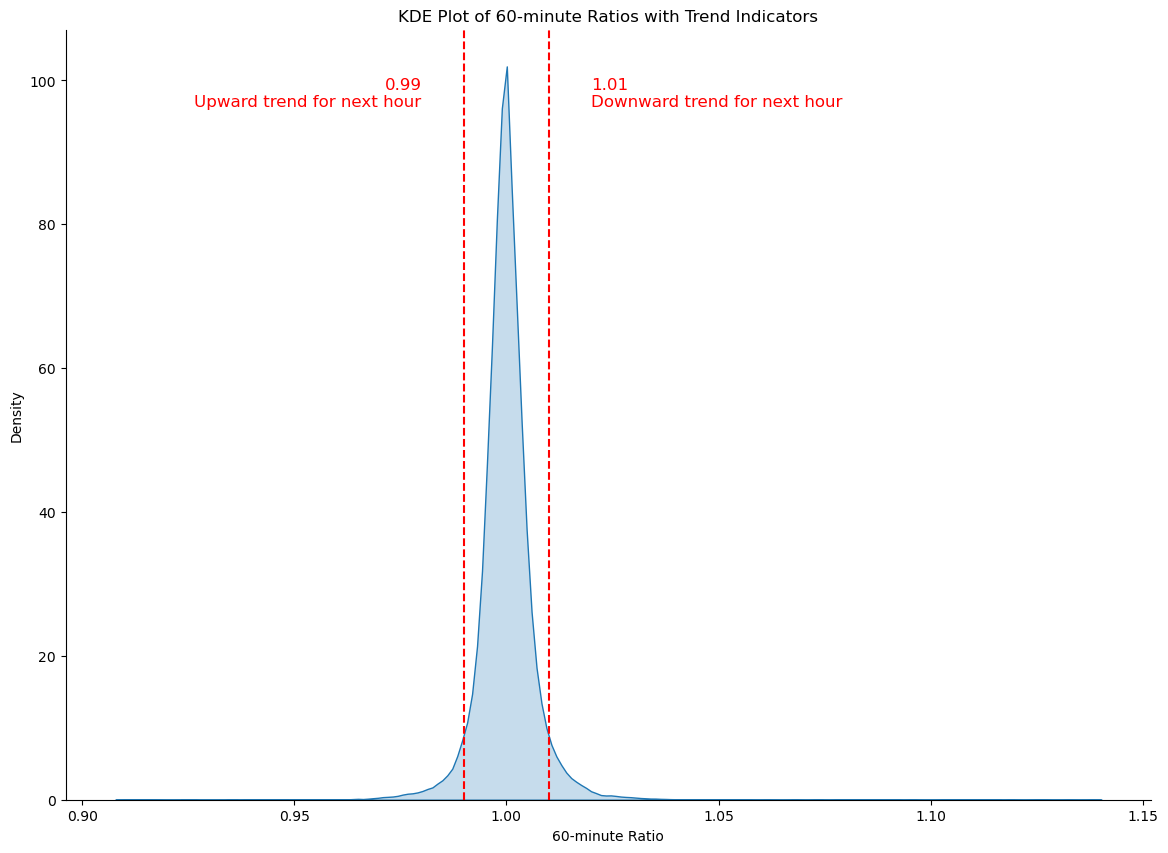

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the 60-minute ratio
filtered_df['60_ratio'] = filtered_df['close'] / filtered_df['close'].shift(-60)  # CP/CP in 60 mins

# Plot the KDE
plt.figure(figsize=(14, 10))
sns.kdeplot(filtered_df['60_ratio'].dropna(), fill=True)

# Add vertical lines for 0.99 and 1.01
plt.axvline(x=0.99, color='red', linestyle='--')
plt.axvline(x=1.01, color='red', linestyle='--')

# Add annotations with adjusted positions
plt.text(0.98, plt.ylim()[1] * 0.9, '0.99\nUpward trend for next hour', color='red', ha='right', fontsize=12)
plt.text(1.02, plt.ylim()[1] * 0.9, '1.01\nDownward trend for next hour', color='red', ha='left', fontsize=12)

# Set plot labels and title
plt.xlabel('60-minute Ratio')
plt.ylabel('Density')
plt.title('KDE Plot of 60-minute Ratios with Trend Indicators')
sns.despine()
plt.show()

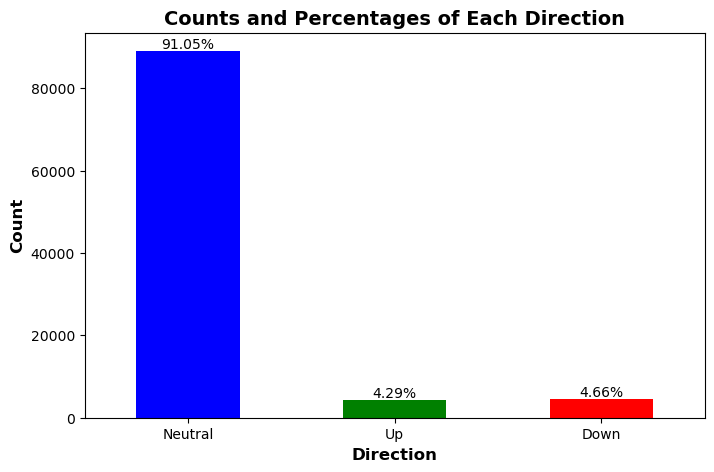

In [5]:
# Determining class counts
def categorize_direction(value):
    if value <= 0.99:
        return 1  # Up
    elif 0.99 < value < 1.01:
        return 0  # Neutral
    else:
        return 2  # Down

# Apply the function to create the 'Direction' column
filtered_df['Direction'] = filtered_df['60_ratio'].apply(categorize_direction)

direction_counts = filtered_df['Direction'].value_counts().sort_index()

# Calculate the percentage of each group
direction_percentages = (direction_counts / direction_counts.sum()) * 100

# Plot the counts
plt.figure(figsize=(8, 5))
bars = direction_counts.plot(kind='bar', color=['blue', 'green', 'red'])

# Add percentage labels on top of the bars
for bar, percentage in zip(bars.patches, direction_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{percentage:.2f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        
    )

plt.title('Counts and Percentages of Each Direction',fontsize = 14, fontweight = 'bold')
plt.xlabel('Direction',fontsize=12,fontweight='bold')
plt.ylabel('Count',fontsize=12,fontweight = 'bold')
plt.xticks(ticks=[0, 1, 2], labels=['Neutral', 'Up', 'Down'], rotation=0)
plt.show()

In [6]:
filtered_df['Direction'].value_counts()

Direction
0    88989
2     4551
1     4194
Name: count, dtype: int64

* Above we can see there class weights for the up and down classes is about even while the neutral class makes up the majority of the data, this is expected when dealing with stock pricing.
------------------------

Below are some descriptive statistics for the input variables

In [7]:
input_vars = filtered_df.drop(columns = 'Direction')
htmldf(input_vars.describe())

,close,AD,OBV,TOS_STDEVALL_LR,MSFT,GOOGL,META,WMT,BABA,peak,epeak,valley,evalley,g_peak,m_peak,w_peak,b_peak,ms_peak,g_valley,m_valley,w_valley,b_valley,ms_valley,720w_ratio,A_M_ratio,A_B_ratio,A_G_ratio,A-B,A-MS,close_diff_1,close_diff_2,close_diff_3,close_diff_4,close_diff_5,Close_Discretized,60_ratio
count,97734.000000,9.773400e+04,9.773400e+04,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.00000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97734.000000,97674.000000
mean,161.667346,1.191625e+06,2.827027e+06,161.604314,387.843204,149.125010,407.426621,117.855673,78.643229,0.233665,0.063264,0.233675,0.06397,0.199808,0.174903,0.133689,0.146807,0.179774,0.200565,0.174279,0.132983,0.146541,0.180408,0.997000,0.403524,2.081600,1.084596,83.024117,-226.175858,0.000263,0.000524,0.000788,0.001050,0.001311,1.500143,0.999924
std,22.067716,9.400069e+05,1.712796e+06,20.585004,42.091417,18.214551,84.559828,48.610114,6.590654,0.423164,0.243438,0.423170,0.24470,0.399858,0.379886,0.340320,0.353915,0.384001,0.400425,0.379351,0.339559,0.353649,0.384529,0.058176,0.035889,0.386936,0.083052,26.292432,21.994987,0.152298,0.214208,0.262271,0.299808,0.332447,1.118085,0.006854
min,124.480000,-2.726624e+05,-6.223696e+04,126.087660,312.680000,123.460000,286.360000,58.810000,68.477200,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337901,0.330001,1.420903,0.913658,38.370000,-266.735000,-8.545000,-8.610000,-11.150000,-11.600000,-11.670000,0.000000,0.909862
25%,141.580000,1.962784e+05,1.238898e+06,143.715847,347.910000,135.250000,319.380000,64.890000,73.555000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994436,0.369011,1.643362,1.037994,54.650000,-241.405000,-0.050000,-0.070000,-0.090000,-0.100000,-0.115000,1.000000,0.996986
50%,166.860000,1.602555e+06,3.643736e+06,161.845381,401.255000,141.380000,432.460000,154.760000,76.490000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001671,0.401407,2.195008,1.072120,90.967500,-230.565000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.999832
75%,182.010000,2.024895e+06,4.370175e+06,179.617670,420.613750,166.463750,488.910000,161.520000,83.435000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.009272,0.435219,2.390326,1.122548,105.710000,-213.075000,0.050000,0.075000,0.095000,0.110000,0.120000,3.000000,1.002655
max,199.745000,2.696474e+06,4.857056e+06,196.350906,463.737800,189.530000,530.855600,174.340000,96.192800,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.087927,0.476935,2.768031,1.357559,126.985000,-180.450000,9.700000,9.930000,10.790000,9.400000,9.560000,3.000000,1.138204


In [10]:
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.exceptions import ConvergenceWarning
import warnings
import numpy as np

# Function for splitting data without overlap
def split_data(df, validation_start, test_start):
    # Split into training, validation, and test sets
    train_df = df[:validation_start]
    validation_df = df[validation_start:test_start]
    test_df = df[test_start:]
    return train_df, validation_df, test_df

def optimize_memory_usage(df):
    """Optimize memory usage by downcasting data types."""
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

def remove_constant_features(df):
    """Remove constant features from the DataFrame."""
    constant_features = [col for col in df.columns if df[col].nunique() <= 1]
    return df.drop(columns=constant_features)

def train_validate_and_evaluate_model(train_df, validation_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns

    # Initialize incremental learning model
    model = SGDClassifier(loss='log_loss', max_iter=5, tol=None)

    # Get the unique classes for partial_fit
    unique_classes = train_df[target_column].unique()

    total_windows = len(train_df) - lookback_period
    quartiles = [int(total_windows * 0.25), int(total_windows * 0.5), int(total_windows * 0.75)]

    feature_selector = None

    # Iterate over the data to create rolling windows
    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        # Define features and target
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        # Handle NaNs by replacing them with the mean of the column
        X_train = X_train.fillna(X_train.mean())

        # Remove constant features from this window
        X_train = remove_constant_features(X_train)

        if X_train.empty:
            continue

        # Check for sufficient variance before feature selection
        if X_train.var().sum() == 0:
            continue

        # Feature selection
        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)  # Ensure k is not more than number of features

        # Fit feature selector and transform training data
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError:
            continue

        # Incrementally train the model
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", ConvergenceWarning)
                model.partial_fit(X_train, y_train, classes=unique_classes)
        except ValueError:
            continue

        if end - lookback_period in quartiles:
            quartile = quartiles.index(end - lookback_period) + 1
            print(f"Completed {quartile * 25}% of training")

    # After training with rolling windows, validate on the entire validation set
    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    # Handle NaNs by replacing them with the mean of the column
    X_val = X_val.fillna(X_val.mean())

    # Remove constant features from the validation set
    X_val = remove_constant_features(X_val)

    if X_val.empty:
        print("Validation failed due to no non-constant features in validation set")
        return y_val.tolist(), []

    # Ensure that validation data has the same number of features
    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return y_val.tolist(), []

    # Make predictions on validation data
    y_pred_val = model.predict(X_val)
    y_true_val = y_val.tolist()

    # Evaluate the model on validation data
    print(f"Lookback period: {lookback_period}")
    print("Validation Set Performance:")
    print(classification_report(y_true_val, y_pred_val))
    print("Model training and evaluation complete.")

    return y_true_val, y_pred_val

# Optimize memory usage by downcasting data types
filtered_df = filtered_df.drop(columns = ['timestamp','Close_Discretized'])
filtered_df = optimize_memory_usage(filtered_df)

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
y_true_val, y_pred_val = train_validate_and_evaluate_model(train_df, validation_df, lookback_period=1170, target_column='Direction')

# Function to display confusion matrix and scoring metrics
def evaluate_model(y_true, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted')}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')}")
    try:
        print(f"AUC Score: {roc_auc_score(y_true, y_pred, multi_class='ovr')}")
    except ValueError:
        print("AUC Score: Not applicable for multi-class with current configuration")

# Evaluate the model on the validation set
evaluate_model(y_true_val, y_pred_val)


Completed 25% of training
Completed 50% of training
Completed 75% of training
Lookback period: 1170
Validation Set Performance:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18052
           1       0.00      0.00      0.00       738
           2       0.00      0.00      0.00       757

    accuracy                           0.92     19547
   macro avg       0.31      0.33      0.32     19547
weighted avg       0.85      0.92      0.89     19547

Model training and evaluation complete.
Confusion Matrix:
[[18052     0     0]
 [  738     0     0]
 [  757     0     0]]
Accuracy: 0.9235176753466005
Precision: 0.8528848966775889
Recall: 0.9235176753466005
F1 Score: 0.8867970464829826
AUC Score: Not applicable for multi-class with current configuration


/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r